In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api
import scipy.stats.mstats as mstats
kw_test = mstats.kruskalwallis
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import histogram
from statsmodels.stats.anova import anova_lm
from scipy.stats import ttest_ind

from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
import scikits.statsmodels.api as sm

import math

import misc
import corrstats
from nemenyi import kw_nemenyi

#pd.options.display.mpl_style = 'default'   # makes pretty colors for plots

%matplotlib inline

(2.4410345510875615, 0.015524222131207077)
(0.36402849584643454, 0.7158367305270712)
(0.04153184045164876, 0.3892118258766578)
(-0.19258265869547644, 0.11358641065961)


/usr/local/lib/python2.7/dist-packages/pandas/computation/expressions.py:21: UserWarning: The installed version of numexpr 1.4.2 is not supported in pandas and will be not be used
The minimum supported version is 2.1

  "version is 2.1\n".format(ver=ver), UserWarning)


In [2]:
data_all = pd.read_csv('../Analysis/data_20160417.csv')

In [28]:
data_u = data_all[:][data_all['usable'] == 'Y']
data_pen = data_u[:][(data_u['pen_pickup'] == 'P') | (data_u['pen_pickup'] == 'N')] # only data for experiments with pen
data_crfn = data_all[:][(data_all['usable'] == 'Y') | (data_all['series'] == 'C')]

In [4]:
turk_all = pd.read_csv('../Analysis/turk_20160418.csv')

In [8]:
turk_all['source'] = 'turk'

In [27]:
data_all['source'] = 'irl'

In [19]:
turk_condition_map = {'D': 'B', 'B': 'A'}
turk_all['condition'] = [turk_condition_map[x[0]] for x in turk_all['ID']]

In [29]:
combined = data_u.append(turk_all)

In [167]:
for d in (data_crfn, data_u, data_pen, turk_all, combined):
    for X in ('EC', 'FS', 'PT', 'PD', 'Age'):
        d['high_' + X] = ['Y' if x >= np.median(d[X]) else 'N' for x in d[X]]

In [30]:
combined.columns

Index([u'Age', u'Apathetic/Responsive', u'Artificial/Lifelike', u'Awful/Nice', u'Dead/Alive', u'Dislike/Like', u'EC', u'FS', u'Fake/Natural', u'Foolish/Sensible', u'Gender', u'ID', u'Ignorant/Knowledgeable', u'Incompetent/Competent', u'Inert/Interactive', u'Irresponsible/Responsible', u'Machinelike/Humanlike', u'Mechanical/Organic', u'Moving rigidly/Moving elegantly', u'PD', u'PT', u'Stagnant/Lively', u'Unconscious/Conscious', u'Unfriendly/Friendly', u'Unintelligent/Intelligent', u'Unkind/Kind', u'Unpleasant/Pleasant', u'animacy', u'anthropomorphic', u'condition', u'empathize', u'intelligence', u'likeability', u'pen_pickup', u'pets', u'post_bad', u'pre_bad', u'revisit', u'series', u'source', u'stressful', u'usable', u'will_erase'], dtype='object')

In [31]:
d = combined
for metric in ('pre_bad', 'post_bad', 'anthropomorphic', 'animacy', 'likeability', 'intelligence'):
    group1 = d[metric][d['source'] == 'turk']
    group2 = d[metric][d['source'] == 'irl']
    print '>>>>>', metric
    print 'shapiro', shapiro(d[metric])
    print 'turk:', np.mean(group1), np.median(group1), len(group1)
    print 'irl:', np.mean(group2), np.median(group2), len(group2)
    print 'MW-U', mannwhitneyu(group1, group2)

>>>>> pre_bad
shapiro (0.8399193286895752, 3.041851926594008e-12)
turk: 2.25833333333 2.0 120
irl: 3.17021276596 3.0 47
MW-U (1839.5, 0.00015034743799694601)
>>>>> post_bad
shapiro (nan, 1.0)
turk: nan nan 120
irl: 3.46808510638 4.0 47
MW-U (0.0, 5.0741552809941472e-24)
>>>>> anthropomorphic
shapiro (0.9245650172233582, 1.2191345888368232e-07)
turk: 2.04666666667 1.8 120
irl: 2.74893617021 2.6 47
MW-U (1671.0, 2.0595092573314166e-05)
>>>>> animacy
shapiro (0.9799643754959106, 0.016177764162421227)
turk: 2.61666666663 2.5 120
irl: 3.1014184397 3.166666667 47
MW-U (1984.5, 0.0014525521183927038)
>>>>> likeability
shapiro (0.9405418634414673, 1.920487875395338e-06)
turk: 3.61666666667 3.6 120
irl: 4.06914893617 4.2 47
MW-U (1941.5, 0.00084464784381427173)
>>>>> intelligence
shapiro (0.9870237708091736, 0.1251356154680252)
turk: 2.87722222227 2.866666667 120
irl: 3.1917730496 3.1 47
MW-U (2336.5, 0.042791911418458707)


## Effect of stories on how bad people feel for robot

I am going to see if the two conditions show a difference in reported pre_bad

then check breakdown by turk (video and story only), irl pre_bad (video, story + short interaction), irl post_bad (video, story + erasure)

In [306]:
d = combined
for metric in ('pre_bad',):
    group1 = d[metric][d['condition'] == 'A']
    group2 = d[metric][d['condition'] == 'B']
    print '>>>>>', metric
    print 'shapiro', shapiro(d[metric])
    print 'A:', np.mean(group1), np.median(group1), len(group1)
    print 'B:', np.mean(group2), np.median(group2), len(group2)
    print 'MW-U', mannwhitneyu(group1, group2)

>>>>> pre_bad
shapiro (0.8399193286895752, 3.041851926594008e-12)
A: 2.16470588235 2.0 85
B: 2.87804878049 3.0 82
MW-U (2528.0, 0.0007527632626668846)


### report that pre_bad is higher for experiment condition
shapiro (0.8399193286895752, 3.041851926594008e-12)

A: 2.16470588235 2.0 85

B: 2.87804878049 3.0 82

*MW-U (2528.0, 0.0007527632626668846)*

> now breakdown by groups

In [282]:
# condition A
groupA_t = combined['pre_bad'][(combined['condition'] == 'A') & (combined['source'] == 'turk')]
groupA_i = combined['pre_bad'][(combined['condition'] == 'A') & (combined['source'] == 'irl')]
groupA_im = combined['post_bad'][(combined['condition'] == 'A') & (combined['source'] == 'irl')]

# condition B
groupB_t = combined['pre_bad'][(combined['condition'] == 'B') & (combined['source'] == 'turk')]
groupB_i = combined['pre_bad'][(combined['condition'] == 'B') & (combined['source'] == 'irl')]
groupB_im = combined['post_bad'][(combined['condition'] == 'B') & (combined['source'] == 'irl')]

condA_means = [np.mean(x) for x in (groupA_t, groupA_i, groupA_im)]
condA_stdev = [np.std(x)/math.sqrt(len(x)) for x in (groupA_t, groupA_i, groupA_im)]

condB_means = [np.mean(x) for x in (groupB_t, groupB_i, groupB_im)]
condB_stdev = [np.std(x)/math.sqrt(len(x)) for x in (groupB_t, groupB_i, groupB_im)]


In [62]:
condA

[1.8333333333333333, 2.96, 3.3999999999999999]

In [63]:
condB

[2.6833333333333331, 3.4090909090909092, 3.5454545454545454]

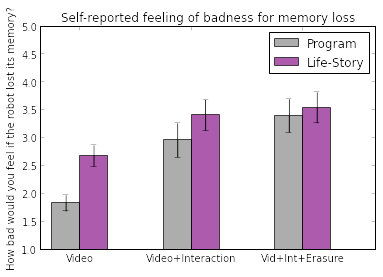

In [298]:
# bar chart of above
ind = np.arange(3)
width = 0.25
fig, ax = plt.subplots()
rects1 = ax.bar(ind + 0.1, condA_means, width, color='gray', alpha=0.8, yerr=condA_stdev, ecolor='k')
rects2 = ax.bar(ind + width + 0.1, condB_means, width, color='purple', alpha=0.8, yerr=condB_stdev, ecolor='k')

# add some text for labels, title and axes ticks
ax.set_ylabel('How bad would you feel if the robot lost its memory?')
ax.set_title('Self-reported feeling of badness for memory loss')
ax.set_xticks(ind + width + 0.1)
ax.set_xticklabels(('Video', 'Video+Interaction', 'Vid+Int+Erasure'))
ax.set_ylim([1.0, 5.0])

ax.legend((rects1[0], rects2[0]), ('Program', 'Life-Story'))

plt.show()

In [67]:
for (A, B) in zip((groupA_t, groupA_i, groupA_im), (groupB_t, groupB_i, groupB_im)):
    print
    print 'A:', np.mean(A), np.std(A)/math.sqrt(len(A)), len(A)
    print 'B:', np.mean(B), np.std(B)/math.sqrt(len(B)), len(B)
    print 'MW-U', mannwhitneyu(A, B)   


A: 1.83333333333 0.145614915801 60
B: 2.68333333333 0.190746583873 60
MW-U (1218.0, 0.00063493363709897911)

A: 2.96 0.307141661127 25
B: 3.40909090909 0.277675496655 22
MW-U (229.5, 0.16334141368796795)

A: 3.4 0.299332590942 25
B: 3.54545454545 0.278182358342 22
MW-U (265.0, 0.41741573670875343)


# Godspeed

In [70]:
d = combined
for metric in ('anthropomorphic', 'animacy', 'likeability', 'intelligence'):
    group1 = d[metric][d['condition'] == 'A']
    group2 = d[metric][d['condition'] == 'B']
    print '>>>>>', metric
    print 'shapiro', shapiro(d[metric])
    print 'A:', np.mean(group1), np.median(group1), len(group1)
    print 'B:', np.mean(group2), np.median(group2), len(group2)
    print 'MW-U', mannwhitneyu(group1, group2)

>>>>> anthropomorphic
shapiro (0.9245650172233582, 1.2191345888368232e-07)
A: 1.89882352941 1.8 85
B: 2.60243902439 2.4 82
MW-U (2121.0, 5.9528827758279519e-06)
>>>>> animacy
shapiro (0.9799643754959106, 0.016177764162421227)
A: 2.42470588228 2.333333333 85
B: 3.09349593498 3.0 82
MW-U (2086.5, 3.6548094694948634e-06)
>>>>> likeability
shapiro (0.9405418634414673, 1.920487875395338e-06)
A: 3.48529411765 3.4 85
B: 4.01219512195 3.8 82
MW-U (2054.5, 2.1080677233249681e-06)
>>>>> intelligence
shapiro (0.9870237708091736, 0.1251356154680252)
A: 2.69976470589 2.733333333 85
B: 3.24146341466 3.0833333335 82
MW-U (2251.0, 3.9170197146365035e-05)


In [289]:
def barchart_turk_irl_measure(measure, dataset, filename=None):
    # condition A
    groupA_t = dataset[measure][(dataset['condition'] == 'A') & (dataset['source'] == 'turk')]
    groupA_i = dataset[measure][(dataset['condition'] == 'A') & (dataset['source'] == 'irl')]


    # condition B
    groupB_t = dataset[measure][(dataset['condition'] == 'B') & (dataset['source'] == 'turk')]
    groupB_i = dataset[measure][(dataset['condition'] == 'B') & (dataset['source'] == 'irl')]


    condA_means = [np.mean(x) for x in (groupA_t, groupA_i)]
    condA_stdev = [np.std(x)/math.sqrt(len(x)) for x in (groupA_t, groupA_i)]

    condB_means = [np.mean(x) for x in (groupB_t, groupB_i)]
    condB_stdev = [np.std(x)/math.sqrt(len(x)) for x in (groupB_t, groupB_i)]

    # bar chart of above
    ind = np.arange(2)
    width = 0.25
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind + 0.1, condA_means, width, color='gray', alpha=0.8, yerr=condA_stdev, ecolor='k')
    rects2 = ax.bar(ind + width + 0.1, condB_means, width, color='purple', alpha=0.8, yerr=condB_stdev, ecolor='k')

    # add some text for labels, title and axes ticks
    ax.set_ylabel(measure)
    ax.set_title(measure)
    ax.set_xticks(ind + width + 0.1)
    ax.set_xticklabels(('Video', 'Video+interaction'))
    ax.set_ylim([1.0, 5.0])

    ax.legend((rects1[0], rects2[0]), ('Program', 'Life-Story'))

    plt.show()
    for (A, B) in zip((groupA_t, groupA_i), (groupB_t, groupB_i)):
        print
        print 'A:', np.mean(A), np.std(A)/math.sqrt(len(A)), len(A)
        print 'B:', np.mean(B), np.std(B)/math.sqrt(len(B)), len(B)
        print 'MW-U', mannwhitneyu(A, B)   



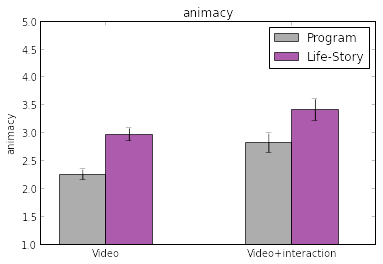


A: 2.25833333327 0.0940699273649 60
B: 2.975 0.113163339288 60
MW-U (1002.0, 1.3485425629042308e-05)

A: 2.82399999992 0.172031211622 25
B: 3.41666666673 0.192772888635 22
MW-U (184.5, 0.027174663014348528)


In [290]:
barchart_turk_irl_measure('animacy', combined)

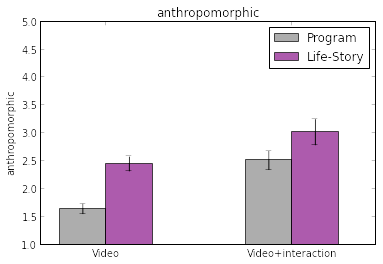


A: 1.64333333333 0.0923870681988 60
B: 2.45 0.133551904184 60
MW-U (937.0, 2.6583007468329544e-06)

A: 2.512 0.169735794693 25
B: 3.01818181818 0.234224265954 22
MW-U (220.0, 0.12183551694810446)


In [291]:
barchart_turk_irl_measure('anthropomorphic', combined)

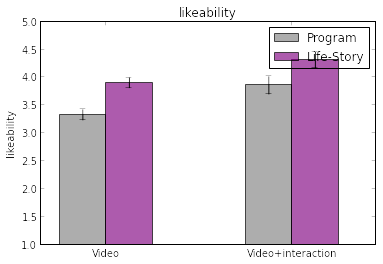


A: 3.33 0.0989753055621 60
B: 3.90333333333 0.0948087744025 60
MW-U (917.0, 1.6085215175977795e-06)

A: 3.858 0.162571338187 25
B: 4.30909090909 0.145867183292 22
MW-U (185.5, 0.02746930454177943)


In [292]:
barchart_turk_irl_measure('likeability', combined)

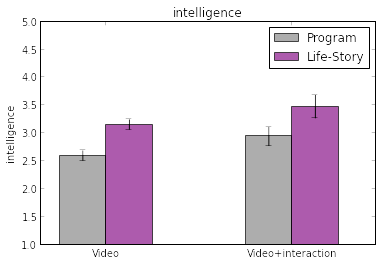


A: 2.59888888893 0.093995556326 60
B: 3.1555555556 0.0941618866882 60
MW-U (1060.5, 5.2291084812735744e-05)

A: 2.9418666666 0.170517234591 25
B: 3.47575757573 0.209652099539 22
MW-U (206.0, 0.07201708017642526)


In [293]:
barchart_turk_irl_measure('intelligence', combined)

In [97]:
ax.boxplot

<bound method AxesSubplot.boxplot of <matplotlib.axes.AxesSubplot object at 0x679a4d0>>

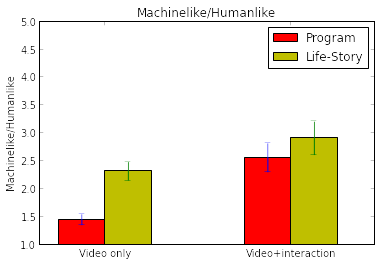


A: 1.45 0.0983898142876 60
B: 2.31666666667 0.165817280072 60
MW-U (1100.5, 3.1288922830395992e-05)

A: 2.56 0.259722929292 25
B: 2.90909090909 0.30088774237 22
MW-U (237.0, 0.20669541003261604)


In [102]:
barchart_turk_irl_measure('Machinelike/Humanlike', combined)

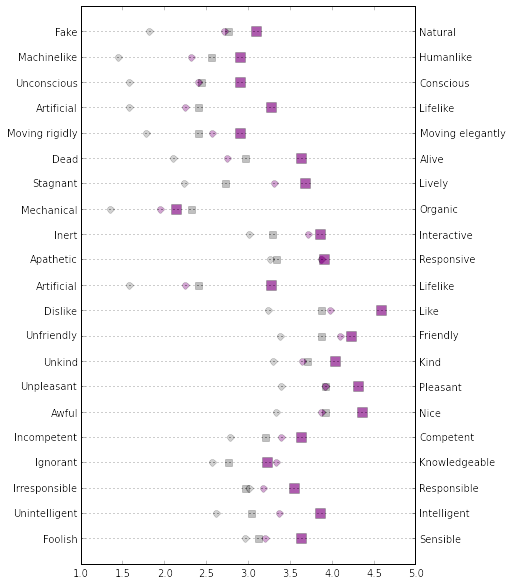

In [165]:
df = combined
                
                
                 
               
                 

gs_anthropomorphic = [u'Fake/Natural', u'Machinelike/Humanlike', u'Unconscious/Conscious', 
              u'Artificial/Lifelike', u'Moving rigidly/Moving elegantly',]
gs_animacy = [u'Dead/Alive',u'Stagnant/Lively', u'Mechanical/Organic', u'Inert/Interactive',
              u'Apathetic/Responsive', u'Artificial/Lifelike']
gs_likeability = [u'Dislike/Like', u'Unfriendly/Friendly', u'Unkind/Kind', 
                  u'Unpleasant/Pleasant', u'Awful/Nice']
gs_intelligence = [u'Incompetent/Competent', u'Ignorant/Knowledgeable', u'Irresponsible/Responsible',
                   u'Unintelligent/Intelligent', u'Foolish/Sensible']

gs_columns = gs_anthropomorphic + gs_animacy + gs_likeability + gs_intelligence
gs_columns.reverse()
gs_left = [x.split('/')[0] for x in gs_columns]
gs_right = [x.split('/')[1] for x in gs_columns]

indices = np.arange(len(gs_columns))

meansB_t = [np.mean(df[x][(df['condition'] == 'B') & (df['source'] == 'turk')]) for x in gs_columns]
meansB_i = [np.mean(df[x][(df['condition'] == 'B') & (df['source'] == 'irl')]) for x in gs_columns]
meansA_t = [np.mean(df[x][(df['condition'] == 'A') & (df['source'] == 'turk')]) for x in gs_columns]
meansA_i = [np.mean(df[x][(df['condition'] == 'A') & (df['source'] == 'irl')]) for x in gs_columns]



fig, ax = plt.subplots(figsize=(6,10))
ax2 = ax.twinx()

rects = ax.plot(meansA_i, indices, marker='s', color='gray', linewidth=0, ms=7.0, alpha=0.7, label='Program - Interaction')
rects = ax.plot(meansB_t, indices, marker='o', color='purple', linewidth=0, ms=7.0, alpha=0.6, label='Life-Story - Video')
rects = ax.plot(meansA_t, indices, marker='o', color='gray', linewidth=0, ms=7.0, alpha=0.6, label='Program - Video',)

rects = ax2.plot(meansB_i, indices, marker='s', color='purple', linewidth=0, ms=10.0, alpha=0.8, label='Life-Story - Interaction')
                 
ax.yaxis.grid(True)
ax.set_xlim([1.0, 5.0])
ax.set_ylim([-1, 21])
ax.set_yticks(indices)
ax.set_yticklabels(gs_left,  ha='right')
#ax.yaxis.set_visible(False)


ax2.yaxis.grid(True)
ax2.set_xlim([1.0, 5.0])
ax2.set_ylim([-1, 21])
ax2.set_yticks(indices)
ax2.set_yticklabels(gs_right, ha='left')

#plt.legend()

plt.margins(0.1)
plt.show()


# Empathy


In [182]:
reload(misc)

<module 'misc' from 'misc.py'>

In [301]:

def plot_interaction(cat, df, measure='pre_bad'):
    print 'analyzing' + cat
    misc.pub_my_interaction_plot(df, 'high_' + cat, 'condition', measure, 
                                 x_levels=['N', 'Y'],
                                x_labels = ['low empathy (' + cat + ')', 'high empathy (' + cat +')'],
                                 trace_labels = ['Programmed', 'Life-story']
                                )
    
    group0 = d[measure][(d['condition'] == 'A') & (d['high_' + cat] == 'Y')]
    group1 = d[measure][(d['condition'] == 'B') & (d['high_' + cat] == 'Y')]
    group2 = d[measure][(d['condition'] == 'A') & (d['high_' + cat] == 'N')]
    group3 = d[measure][(d['condition'] == 'B') & (d['high_' + cat] == 'N')]

    print 'KW:', kw_test(group0, group1, group2, group3)
    # compare=((0,1), (2,3), (0,2), (1,3)) - compared b and d with empathy high and low, then high and low empathy for each of b and d
    print 'Nemenyi', kw_nemenyi((group0, group1, group2, group3), to_compare=((0,1), (2,3), (0,2), (1,3)))

    formula = measure + ' ~ C(condition)*' + cat
    lm = ols(formula, df).fit()
    print lm.summary()
    #fig, ax = plt.subplots()
    #fig = statsmodels.api.graphics.plot_fit(lm, 2, ax=ax)
    print anova_lm(lm)
    print '> normality of residuals', shapiro(lm.resid)
    
   

analyzingEC
got x_levels ['N', 'Y']
got trace_levels set(['A', 'B'])
0 N A 1.9696969697 1.21816674195 33 0.342880231428
1 Y A 1.66666666667 0.981306762925 27 0.32075014955
0 N B 2.57692307692 1.59742766595 26 0.505376194395
1 Y B 2.76470588235 1.37324912117 34 0.474143147159
KW: (3.5863632130693981, 0.30973263005428181)
Nemenyi (3.5863632130693981, 0.30973263005428181, array([ 0.42012364,  0.9       ,  0.9       ,  0.39767015]), array([False, False, False, False], dtype=bool))
                            OLS Regression Results                            
Dep. Variable:                pre_bad   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     7.466
Date:                Wed, 20 Apr 2016   Prob (F-statistic):           0.000130
Time:                        22:23:07   Log-Likelihood:                -198.45
No. Observations:                 120   AIC:

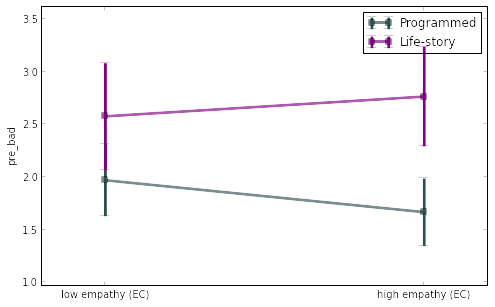

In [302]:
plot_interaction('EC', turk_all)

analyzingFS
got x_levels ['N', 'Y']
got trace_levels set(['A', 'B'])
0 N A 2.03333333333 1.22429117815 30 0.371234177865
1 Y A 1.63333333333 0.982626864866 30 0.298204503531
0 N B 2.34615384615 1.4660860425 26 0.460118624747
1 Y B 2.94117647059 1.43365383611 34 0.50440760336
KW: (12.429726841154752, 0.00604713196687262)
Nemenyi (12.429726841154752, 0.00604713196687262, array([ 0.01560466,  0.63007325,  0.9       ,  0.45368808]), array([ True, False, False, False], dtype=bool))
                            OLS Regression Results                            
Dep. Variable:                pre_bad   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     5.552
Date:                Wed, 20 Apr 2016   Prob (F-statistic):            0.00135
Time:                        17:35:27   Log-Likelihood:                -200.99
No. Observations:                 120   AIC:

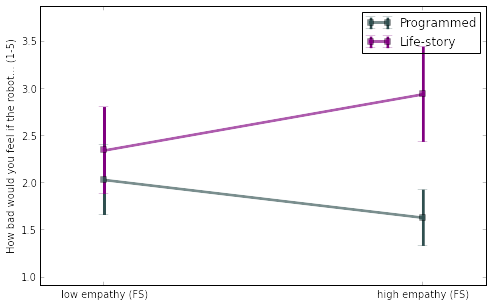

In [193]:
plot_interaction('FS', turk_all)

analyzingPT
got x_levels ['N', 'Y']
got trace_levels set(['A', 'B'])
0 N A 2.0 1.3130643286 29 0.371390676354
1 Y A 1.67741935484 0.893961707132 31 0.301273409851
0 N B 2.625 1.60240704359 24 0.535825881234
1 Y B 2.72222222222 1.38666488604 36 0.453703703704
KW: (10.921022477198598, 0.012160693101594067)
Nemenyi (10.921022477198598, 0.012160693101594067, array([ 0.02149791,  0.51118264,  0.9       ,  0.89385319]), array([ True, False, False, False], dtype=bool))
                            OLS Regression Results                            
Dep. Variable:                pre_bad   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.421
Date:                Wed, 20 Apr 2016   Prob (F-statistic):            0.00556
Time:                        20:23:13   Log-Likelihood:                -202.55
No. Observations:                 120   AIC:               

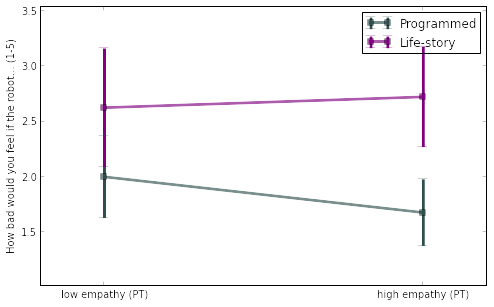

In [194]:
plot_interaction('PT', turk_all)

analyzingPD
got x_levels ['N', 'Y']
got trace_levels set(['A', 'B'])
0 N A 1.57142857143 0.979379228629 28 0.296972085936
1 Y A 2.0625 1.19732775379 32 0.364601934049
0 N B 2.53846153846 1.36524918072 26 0.49783326612
1 Y B 2.79411764706 1.54880241714 34 0.479187223192
KW: (12.545539118883154, 0.0057299560143549881)
Nemenyi (12.545539118883154, 0.0057299560143549881, array([ 0.21961023,  0.08089563,  0.55071004,  0.85734729]), array([False, False, False, False], dtype=bool))
                            OLS Regression Results                            
Dep. Variable:                pre_bad   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     4.551
Date:                Wed, 20 Apr 2016   Prob (F-statistic):            0.00472
Time:                        20:24:01   Log-Likelihood:                -202.37
No. Observations:                 120   AIC:  

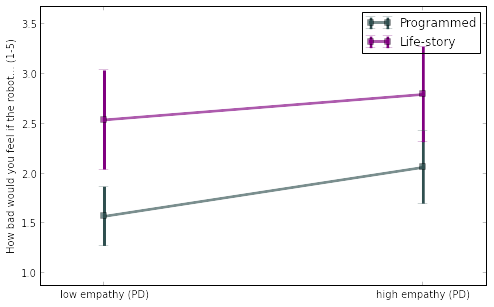

In [195]:
plot_interaction('PD', turk_all)

In [303]:
def barchart_empathy(dataset, measure='pre_bad', filename=None):
    # condition A
    means_high = []
    stdev_high = []
    means_low = []
    stdev_low = []
    
    empathy_cats = ('FS', 'EC', 'PT', 'PD')
    for cat in empathy_cats:
        group_high = dataset[measure][dataset['high_' + cat] == 'Y']
        group_low = dataset[measure][dataset['high_' + cat] == 'N']
        
        means_high.append(np.mean(group_high))
        stdev_high.append(np.std(group_high)/math.sqrt(len(group_high)))

        means_low.append(np.mean(group_low))
        stdev_low.append(np.std(group_low)/math.sqrt(len(group_low)))
        
        A = group_high
        B = group_low
        print '>>>>> ' + cat
        print 'A:', np.mean(A), np.std(A)/math.sqrt(len(A)), len(A)
        print 'B:', np.mean(B), np.std(B)/math.sqrt(len(B)), len(B)
        print 'MW-U', mannwhitneyu(A, B)           
    

    # bar chart of above
    ind = np.arange(len(means_high))
    width = 0.25
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind + 0.1, means_high, width, color='darkcyan', alpha=0.8, yerr=stdev_high, ecolor='k')
    rects2 = ax.bar(ind + width + 0.1, means_low, width, color='gray', alpha=0.8, yerr=stdev_low, ecolor='k')

    # add some text for labels, title and axes ticks
    ax.set_ylabel(measure)
    ax.set_title('Effect of Empathy on ' + measure)
    ax.set_xticks(ind + width + 0.1)
    ax.set_xticklabels(empathy_cats)
    ax.set_ylim([1.0, 5.0])

    ax.legend((rects1[0], rects2[0]), ('High Empathy', 'Low Empathy'))

    plt.show()
  



>>>>> FS
A: 2.328125 0.175466297707 64
B: 2.17857142857 0.180537644573 56
MW-U (1694.5, 0.29502009871863621)
>>>>> EC
A: 2.27868852459 0.170572407713 61
B: 2.23728813559 0.186192412595 59
MW-U (1727.0, 0.34491592669198623)
>>>>> PT
A: 2.23880597015 0.158081548585 67
B: 2.28301886792 0.203873767286 53
MW-U (1734.5, 0.41060208818063981)
>>>>> PD
A: 2.43939393939 0.176862758109 66
B: 2.03703703704 0.173645972723 54
MW-U (1503.5, 0.060756693366021616)


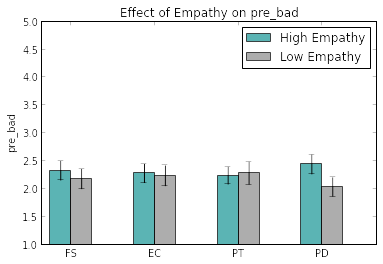

In [304]:
barchart_empathy(turk_all)

>>>>> FS
A: 2.74479166661 0.115289534827 64
B: 2.47023809523 0.108139146249 56
MW-U (1489.0, 0.055271291275820318)
>>>>> EC
A: 2.76229508193 0.112019126743 61
B: 2.46610169488 0.112483283581 59
MW-U (1411.0, 0.020549885713333087)
>>>>> PT
A: 2.67910447758 0.107531385408 67
B: 2.53773584902 0.120620463028 53
MW-U (1593.5, 0.16805140672284158)
>>>>> PD
A: 2.64141414141 0.108629450043 66
B: 2.58641975302 0.119834255675 54
MW-U (1734.5, 0.4018231817259027)


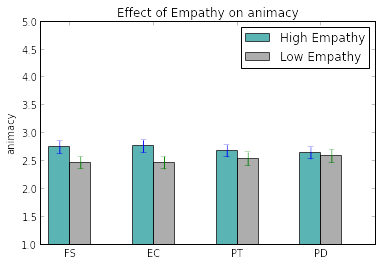

In [231]:
barchart_empathy(turk_all, measure='animacy')


### hmm... I wonder what the empathy interaction looks like with GS measure


In [218]:
reload(misc)

<module 'misc' from 'misc.py'>

analyzingFS
got x_levels ['N', 'Y']
got trace_levels set(['A', 'B'])
0 N A 2.22222222217 0.721794745251 30 0.405720412957
1 Y A 2.29444444437 0.733690990248 30 0.418906326374
0 N B 2.75641025646 0.810232067139 26 0.540576526352
1 Y B 3.14215686271 0.888499830823 34 0.53887545625
KW: (22.682176171908715, 4.70356227262776e-05)
Nemenyi (22.682176171908715, 4.70356227262776e-05, array([ 0.00909741,  0.0133272 ,  0.58734303,  0.72344873]), array([ True,  True, False, False], dtype=bool))
                            OLS Regression Results                            
Dep. Variable:                animacy   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     10.43
Date:                Wed, 20 Apr 2016   Prob (F-statistic):           3.95e-06
Time:                        20:45:04   Log-Likelihood:                -140.88
No. Observations:                 120 

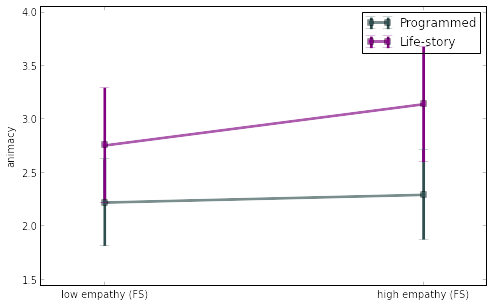

In [221]:
plot_interaction('FS', turk_all, measure='animacy')

analyzingPT
got x_levels ['N', 'Y']
got trace_levels set(['A', 'B'])
0 N A 2.1839080459 0.672880278301 29 0.40554154313
1 Y A 2.32795698919 0.770751008058 31 0.418113418149
0 N B 2.96527777779 0.906482781947 24 0.605284791767
1 Y B 2.98148148147 0.855968314776 36 0.496913580245
KW: (20.169222716645567, 0.00015657203986895908)
Nemenyi (20.169222716645567, 0.00015657203986895908, array([ 0.00526633,  0.01317092,  0.9       ,  0.9       ]), array([ True,  True, False, False], dtype=bool))
                            OLS Regression Results                            
Dep. Variable:                animacy   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     7.994
Date:                Wed, 20 Apr 2016   Prob (F-statistic):           6.87e-05
Time:                        20:45:34   Log-Likelihood:                -143.94
No. Observations:                 1

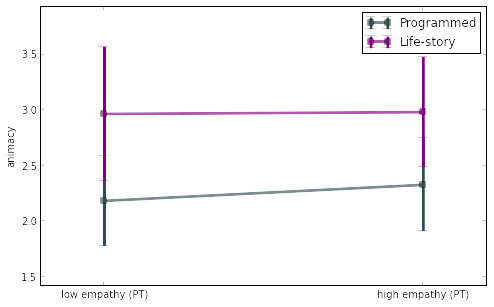

In [222]:
plot_interaction('PT', turk_all, measure='animacy')

analyzingEC
got x_levels ['N', 'Y']
got trace_levels set(['A', 'B'])
0 N A 2.20202020191 0.66762251644 33 0.383322515115
1 Y A 2.32716049381 0.791520755229 27 0.44786224585
0 N B 2.80128205135 0.963011691958 26 0.549376609342
1 Y B 3.10784313721 0.778470883592 34 0.532990700876
KW: (22.947228903511327, 4.1418817647843138e-05)
Nemenyi (22.947228903511327, 4.1418817647843138e-05, array([ 0.00323218,  0.03877317,  0.78644469,  0.48617886]), array([ True,  True, False, False], dtype=bool))
                            OLS Regression Results                            
Dep. Variable:                animacy   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     9.353
Date:                Wed, 20 Apr 2016   Prob (F-statistic):           1.38e-05
Time:                        20:46:21   Log-Likelihood:                -142.22
No. Observations:                 1

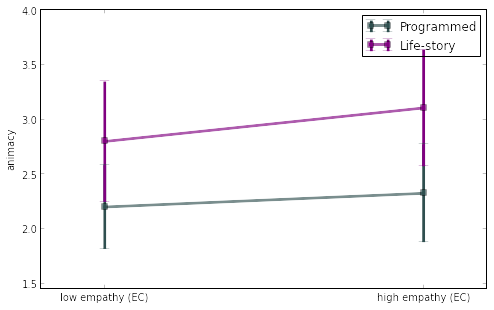

In [224]:
plot_interaction('EC', turk_all, measure='animacy')

# Pen Pickup

I want to see what fraction of people are picking up pens in each category

In [237]:
np.median(data_pen['post_bad'])

4.0

In [239]:
len(data_pen['ID'][data_pen['post_bad'] < 4.0])

16

In [240]:
data_pen['high_post_bad'] = ['Y' if x >= np.median(data_pen['post_bad']) else 'N' for x in data_pen['post_bad']]

In [268]:
data_pen['high_pre_bad'] = ['Y' if x >= np.median(data_pen['pre_bad']) else 'N' for x in data_pen['pre_bad']]

In [252]:
def pen_interaction_plot(df, x='high_post_bad', trace='high_EC', 
                         x_levels=None, trace_levels=None, filename=None,
                            x_labels = None, trace_labels = None):
    """ 
    For publication...

    does a statsmodel style interaction plot grouping the
    'response' column values by x, trace and plotting their mean,
    stdev of mean with a line per level of trace 
    
    provide x_levels and trace_levels if you care about the order
    
    needs
        import matplotlib.pyplot as plt
        import numpy as np
        import math
    
    """
    colors = ['darkcyan', 'gray']
    if x_levels is None:
        x_levels = set(df[x])
    if trace_levels is None:
        trace_levels = set(df[trace])
    
    if x_labels is None:
        x_labels = x_levels
    if trace_labels is None:
        trace_labels = trace_levels

    colors = (colors*len(trace_levels))[:len(trace_levels)]
    print 'got x_levels', x_levels
    print 'got trace_levels', trace_levels
    
    fig, ax = plt.subplots(figsize=(8, 5)) # was 4,3
    plt.ylabel('proportion of people picking up pens')
    #plt.xlabel(x)
    
    for (trace_val, trace_label) in zip(trace_levels, trace_labels):
        x_num_list = []
        y_list = []
        yerr_list = []
        for x_num, x_val in zip(range(len(x_levels)), x_levels):
            responses = df['pen_pickup'][(df[x] == x_val) & (df[trace] == trace_val)]
            num_pickups = sum(responses == 'P')
            num_no_pickups = sum(responses == 'N')
            pickup_prop = float(num_pickups) /  float(num_pickups + num_no_pickups)
            
            x_num_list.append(x_num)
            y_list.append(pickup_prop)
            yerr_list.append(0)
                                   
            print x_num, x_val, trace_val, pickup_prop, len(responses)
        
        plt.errorbar(x_num_list,y_list, yerr=yerr_list, 
                     linewidth=3.0, alpha=0.80, capsize=5.0, marker='s',
                     color=colors.pop(), label=trace_label)
    plt.legend()
    plt.xticks(range(len(x_levels)), list(x_labels))
    plt.margins(0.2)


got x_levels ['N', 'Y']
got trace_levels ['N', 'Y']
0 N N 0.333333333333 9
1 Y N 1.0 8
0 N Y 1.0 7
1 Y Y 0.6 10


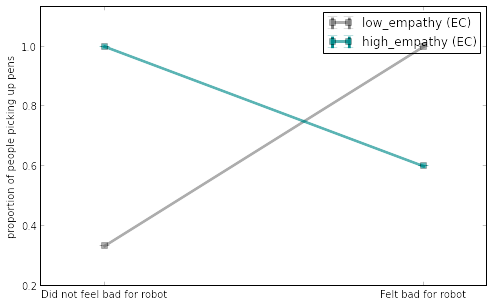

In [308]:
pen_interaction_plot(data_pen, trace = 'high_EC', x_levels = ['N', 'Y'], trace_levels = ['N', 'Y'], 
                    x_labels = ['Did not feel bad for robot', 'Felt bad for robot'],
                    trace_labels = ['low_empathy (EC)', 'high_empathy (EC)'])

got x_levels ['N', 'Y']
got trace_levels ['N', 'Y']
0 N N 0.5 6
1 Y N 0.571428571429 7
0 N Y 0.7 10
1 Y Y 0.909090909091 11


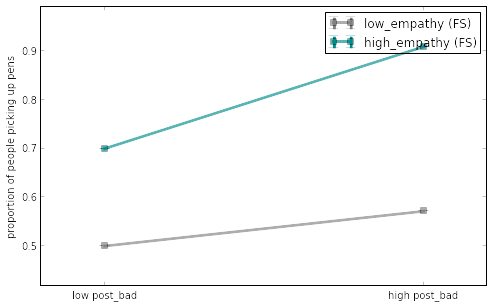

In [255]:
pen_interaction_plot(data_pen, trace = 'high_FS', x_levels = ['N', 'Y'], trace_levels = ['N', 'Y'], 
                    x_labels = ['low post_bad', 'high post_bad'],
                    trace_labels = ['low_empathy (FS)', 'high_empathy (FS)'])

got x_levels ['N', 'Y']
got trace_levels ['N', 'Y']
0 N N 0.625 8
1 Y N 0.75 8
0 N Y 0.625 8
1 Y Y 0.8 10


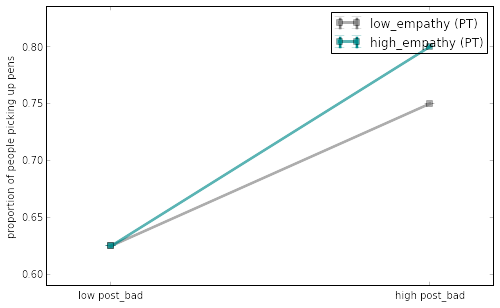

In [256]:
pen_interaction_plot(data_pen, trace = 'high_PT', x_levels = ['N', 'Y'], trace_levels = ['N', 'Y'], 
                    x_labels = ['low post_bad', 'high post_bad'],
                    trace_labels = ['low_empathy (PT)', 'high_empathy (PT)'])

got x_levels ['N', 'Y']
got trace_levels ['N', 'Y']
0 N N 0.7 10
1 Y N 0.571428571429 7
0 N Y 0.5 6
1 Y Y 0.909090909091 11


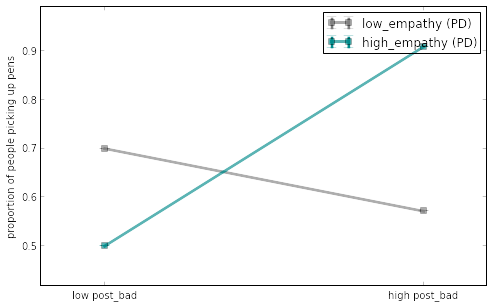

In [258]:
pen_interaction_plot(data_pen, trace = 'high_PD', x_levels = ['N', 'Y'], trace_levels = ['N', 'Y'], 
                    x_labels = ['low post_bad', 'high post_bad'],
                    trace_labels = ['low_empathy (PD)', 'high_empathy (PD)'])

In [270]:
d = data_pen
# checking to see how to explain more people picked up the pen when they felt bad for the robot
formula = 'post_bad ~ C(pen_pickup)*C(high_EC)'
lm = ols(formula, d).fit()
print lm.summary()
#fig, ax = plt.subplots()
#fig = statsmodels.api.graphics.plot_fit(lm, 2, ax=ax)
print anova_lm(lm)
print '> normality of residuals', shapiro(lm.resid)

                            OLS Regression Results                            
Dep. Variable:               post_bad   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     6.453
Date:                Wed, 20 Apr 2016   Prob (F-statistic):            0.00167
Time:                        21:35:35   Log-Likelihood:                -50.128
No. Observations:                  34   AIC:                             108.3
Df Residuals:                      30   BIC:                             114.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Inte

In [272]:
d = data_pen
# checking to see how to explain more people picked up the pen when they felt bad for the robot
formula = 'post_bad ~ C(pen_pickup)*C(high_FS)'
lm = ols(formula, d).fit()
print lm.summary()
#fig, ax = plt.subplots()
#fig = statsmodels.api.graphics.plot_fit(lm, 2, ax=ax)
print anova_lm(lm)
print '> normality of residuals', shapiro(lm.resid)

                            OLS Regression Results                            
Dep. Variable:               post_bad   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                 -0.053
Method:                 Least Squares   F-statistic:                    0.4434
Date:                Wed, 20 Apr 2016   Prob (F-statistic):              0.724
Time:                        21:46:54   Log-Likelihood:                -57.856
No. Observations:                  34   AIC:                             123.7
Df Residuals:                      30   BIC:                             129.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Inte

In [273]:
d = data_pen
# checking to see how to explain more people picked up the pen when they felt bad for the robot
formula = 'post_bad ~ C(pen_pickup)*C(high_PT)'
lm = ols(formula, d).fit()
print lm.summary()
#fig, ax = plt.subplots()
#fig = statsmodels.api.graphics.plot_fit(lm, 2, ax=ax)
print anova_lm(lm)
print '> normality of residuals', shapiro(lm.resid)

                            OLS Regression Results                            
Dep. Variable:               post_bad   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.075
Method:                 Least Squares   F-statistic:                    0.2297
Date:                Wed, 20 Apr 2016   Prob (F-statistic):              0.875
Time:                        21:47:05   Log-Likelihood:                -58.208
No. Observations:                  34   AIC:                             124.4
Df Residuals:                      30   BIC:                             130.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Inte

In [274]:
d = data_pen
# checking to see how to explain more people picked up the pen when they felt bad for the robot
formula = 'post_bad ~ C(pen_pickup)*C(high_PD)'
lm = ols(formula, d).fit()
print lm.summary()
#fig, ax = plt.subplots()
#fig = statsmodels.api.graphics.plot_fit(lm, 2, ax=ax)
print anova_lm(lm)
print '> normality of residuals', shapiro(lm.resid)

                            OLS Regression Results                            
Dep. Variable:               post_bad   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     1.581
Date:                Wed, 20 Apr 2016   Prob (F-statistic):              0.215
Time:                        21:47:26   Log-Likelihood:                -56.099
No. Observations:                  34   AIC:                             120.2
Df Residuals:                      30   BIC:                             126.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Inte